In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
from src.verify import check_MC
from src.utils import same_seed, sample_mask
from src.nonconvex import create_loss_fn
from src.search import create_search_proj_fn, create_search_loss_fn, search
torch.set_printoptions(precision=4)

In [2]:
def extend_matrix(B: torch.tensor):
    num_users, num_movies = B.size()
    # Extend B matrix
    B_ext = torch.zeros((num_users + num_movies, num_users + num_movies))
    B_ext[num_users:, :num_users] = B.T
    B_ext[:num_users, num_users:] = B
    # Create mask
    mask = torch.zeros((num_users + num_movies, num_users + num_movies))
    mask[num_users:, :num_users] = 1
    mask[:num_users, num_users:] = 1

    return B_ext, mask

In [9]:
def compute_Z(B: torch.Tensor, dim=2, iter=1000, lr=0.001):
    B, mask = extend_matrix(B)
    def loss_func(x):
        return ((x @ x.T - B) * mask).square().sum()
    # Initialize
    Z = torch.rand((B.size(0), dim), requires_grad=True)
    loss = []
    for i in range(iter):
        f = ((Z @ Z.T - B) * mask).square().sum()
        # print(hessian(loss_func, Z))
        loss.append(f.item())
        f.backward()
        Z.data = Z.data - lr * Z.grad.data
        Z.grad.data.zero_()
    return Z, B, mask, loss

In [10]:
def loss_fn(Z, f, type='A', coeff=0.1):
    def loss_A(X, E):
        w, h = X.size()
        dist_loss = -torch.linalg.matrix_norm(X - Z)
        first_order_loss = torch.linalg.matrix_norm(grad(f(X, E), X, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (X, E), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return dist_loss + first_order_loss + second_order_loss, dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    def loss_B(X, E):
        w, h = X.size()
        dist_loss = -torch.linalg.matrix_norm(X - Z)
        first_order_loss = torch.linalg.matrix_norm(grad(f(X, E), X, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (X, E), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return dist_loss + coeff * torch.max(first_order_loss, second_order_loss), dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    return loss_A if type == 'A' else loss_B

In [11]:
def compute_X_E(B: torch.Tensor, dim=2, iter=3000, lr=0.001, max_norm=1e-1, loss_type='A', coeff=0.1):
    same_seed(0)
    # Compute the global optimal solution
    Z, B, mask, _ = compute_Z(B, dim, iter, lr)
    def f(x, e):
        return ((x @ x.T - Z @ Z.T + e) * mask).square().sum()
    criterion = loss_fn(Z, f, loss_type, coeff)
    X = torch.rand((B.size(0), dim), requires_grad=True)
    E = torch.zeros(B.size(), requires_grad=True)
    losses = []
    for i in range(iter):
        loss, dist, grad, hess = criterion(X, E)
        losses.append((loss.item(), dist, grad, hess))
        loss.backward()
        # GD
        X.data = X.data - lr * X.grad.data
        E.data = E.data - lr * E.grad.data
        # Clear the gradients
        X.grad.data.zero_()
        E.grad.data.zero_()
        # Restrict the norm of error
        norm_E = torch.linalg.matrix_norm(E * mask)
        if norm_E > np.sqrt(2) * max_norm:
            E.data = E.data / norm_E * np.sqrt(2) * max_norm
        # Adjust learning rate
        if (i + 1) % (iter // 3) == 0:
            lr = lr * 0.1
    return X, E, Z, losses
    

In [12]:
B = torch.tensor([
    [1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1]
])
# Z, _, _, losses = compute_Z(B)
# U = Z[:B.size(0)]
# V = Z[B.size(0):]
# Z_hat = U @ V.T
# print(Z_hat)
embed_dim = 1
E_max_norm = 1e-1
loss_type = 'B'
coeff = 1

X, E, Z, losses = compute_X_E(
    B, 
    embed_dim, 
    max_norm=E_max_norm,
    loss_type=loss_type,
    coeff=coeff
)
# print(X)
# print(Z)
print(B)
print(X[:B.size(0)] @ X[B.size(0):].T)
print(Z[:B.size(0)] @ Z[B.size(0):].T)
print(E)

KeyboardInterrupt: 

In [ ]:
def plot_loss(losses):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    loss = [loss[0] for loss in losses]
    dist = [loss[1] for loss in losses]
    grad = [loss[2] for loss in losses]
    hess = [loss[3] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(dist)
    ax[1][0].plot(grad)
    ax[1][1].plot(hess)

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$G(X,\epsilon)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$-\|X-Z\|$", fontsize=30)
    ax[0][1].set_title(r"$-\|X-Z\|$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X,\epsilon)\|$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X,\epsilon)\|$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X,\epsilon))$", fontsize=30)
    ax[1][1].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X,\epsilon))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()
    

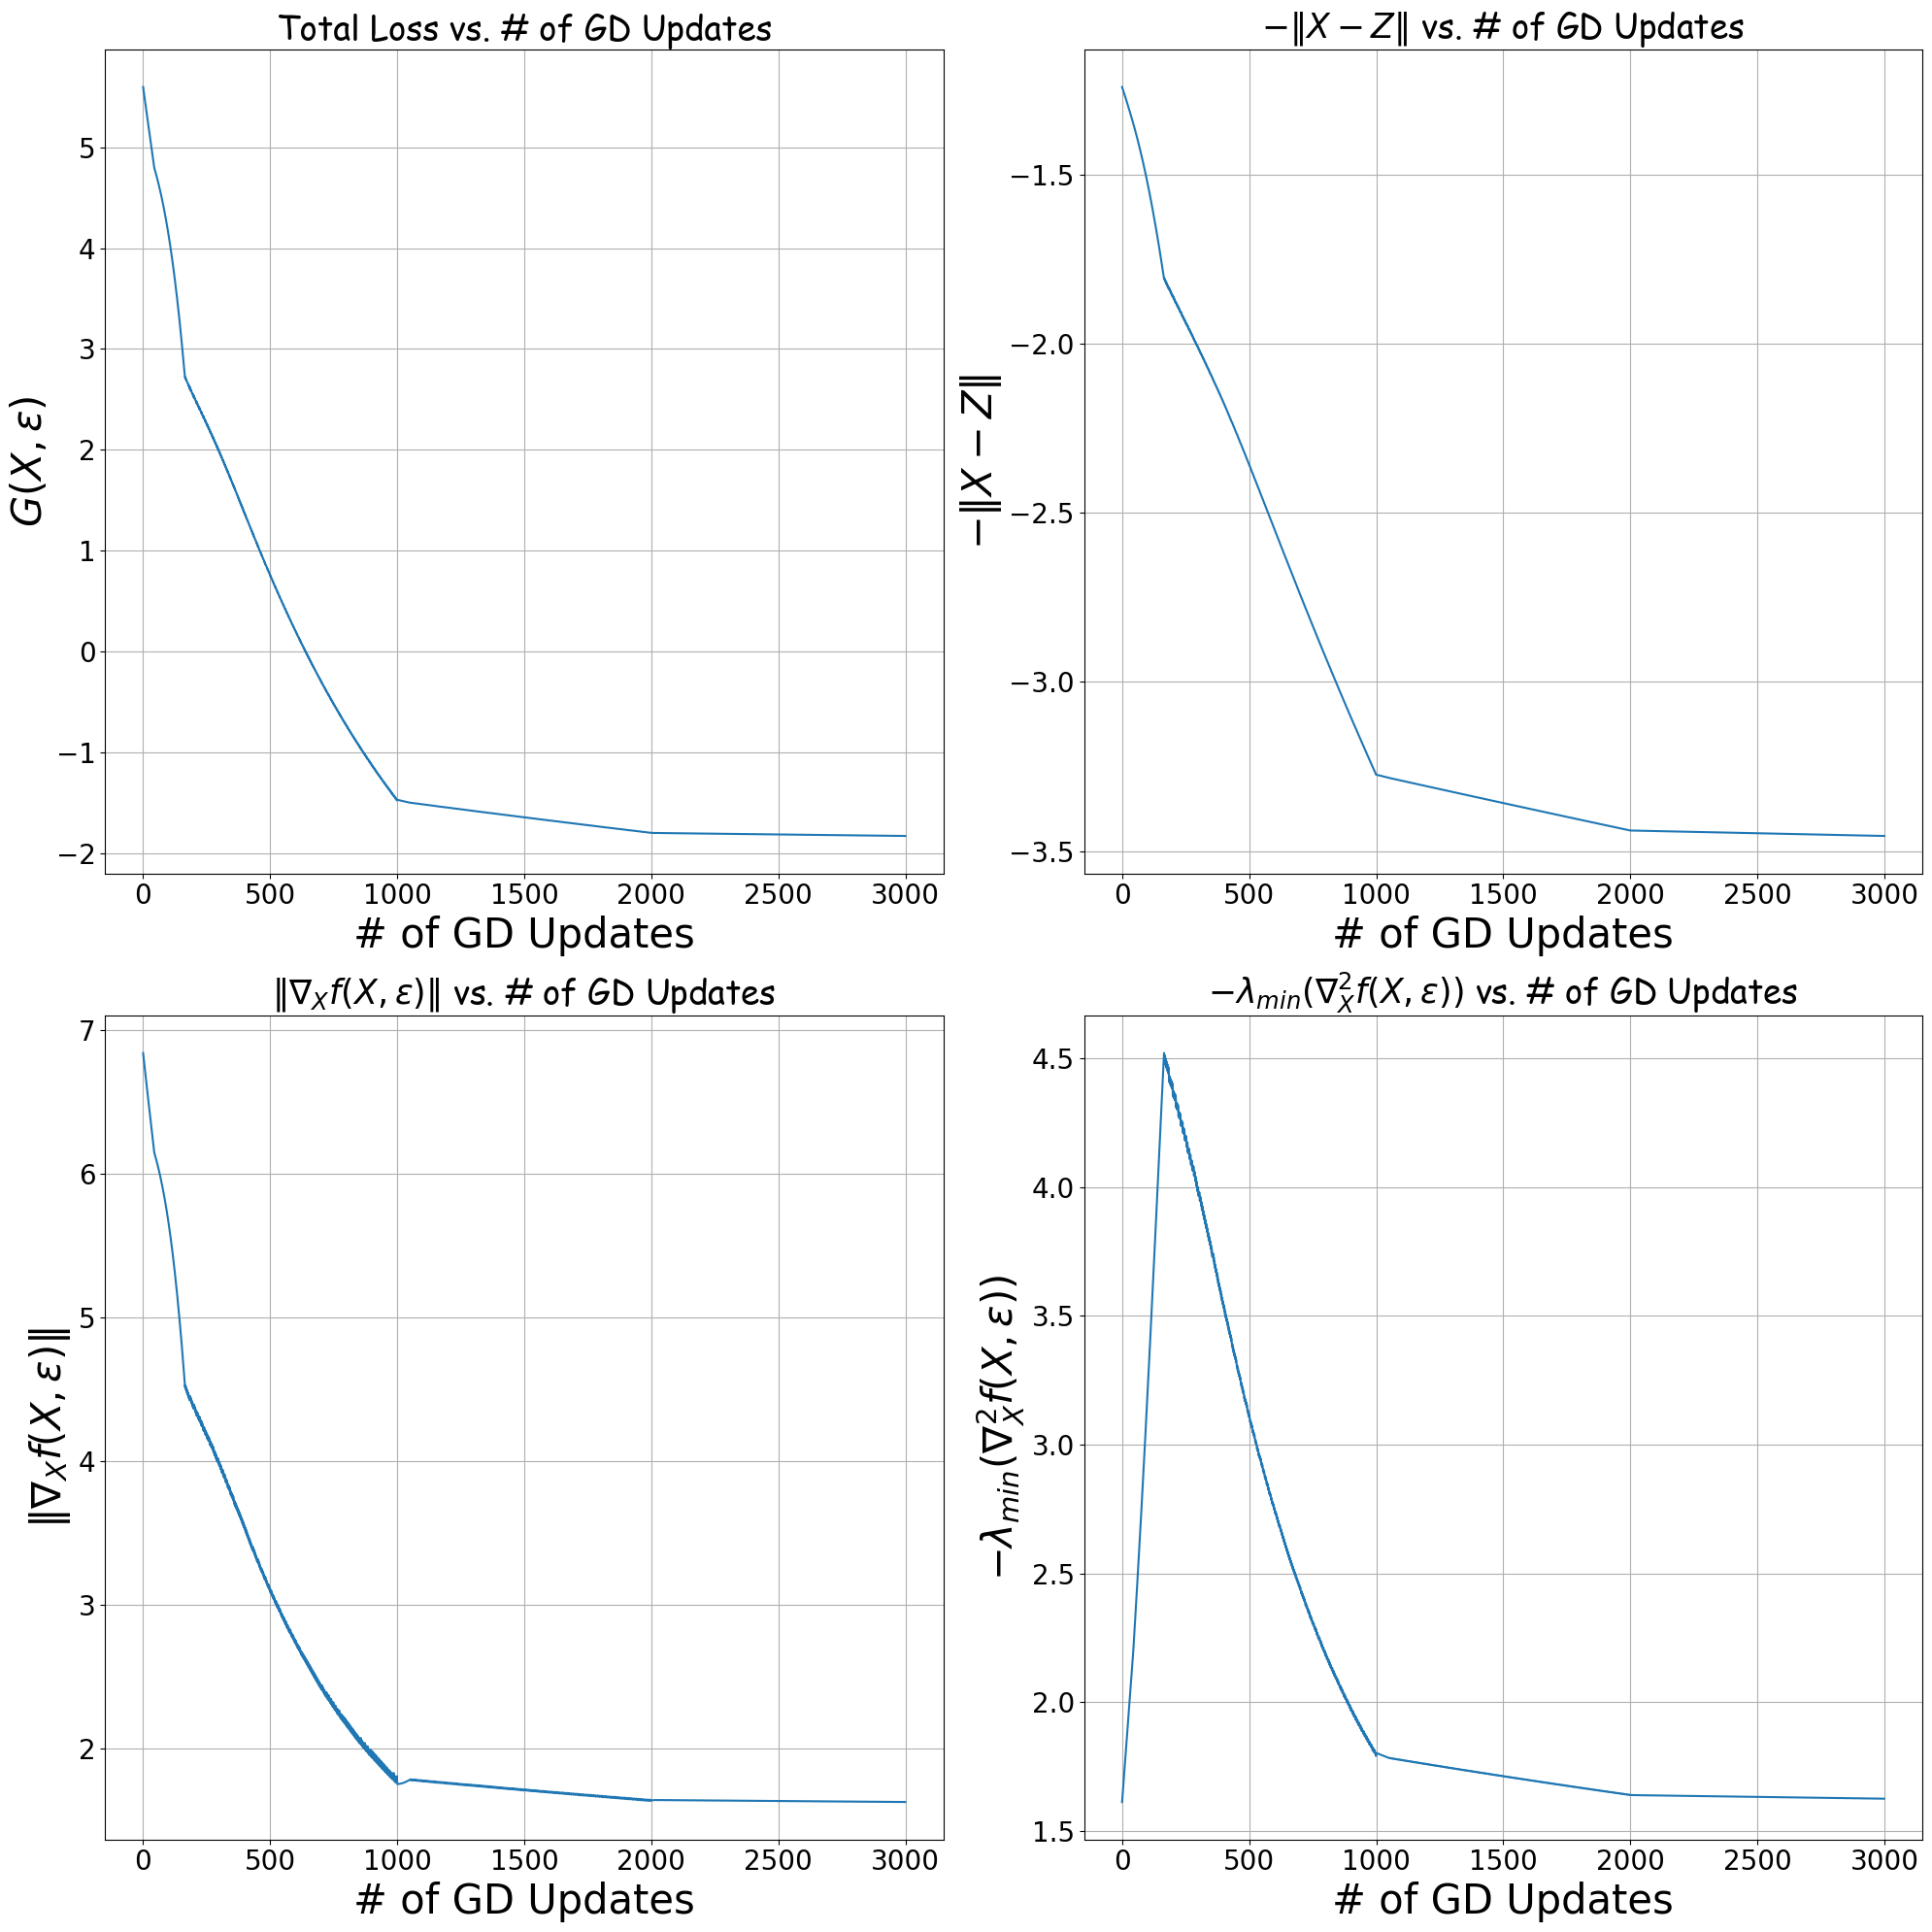

In [ ]:
plot_loss(losses)

In [2]:
def plot_loss_2(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|XX^T-ZZ^T\|_F$", fontsize=30)
    ax[1][1].set_title(r"$-\|XX^T-ZZ^T\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    # ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].grid()

In [3]:
def compute_X_Z_e(n, r, p, mu, e_norm, loss_type='MC_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1e-2, -1e2)):
    mask = torch.tensor(sample_mask(n, n, p), dtype=torch.float32)
    X = torch.normal(0.0, torch.ones((n, r)))
    Z = torch.normal(0.0, torch.ones((n, r)))
    # Z = X + 0.6 * gaussian_vector / torch.linalg.norm(gaussian_vector, ord=torch.inf)
    # print(X)
    # print(Z)
    E = torch.zeros((n, n), requires_grad=True)
    X.requires_grad_()
    Z.requires_grad_()
    parameters = [X, E, Z]
    loss_fn = create_loss_fn('MC_PSD', mask=mask, Z=0, ZL=0, ZR=0, e=0)
    criterion = create_search_loss_fn(loss_fn, loss_type, mask=mask, e=0, Z=0)
    proj_fn = create_search_proj_fn('MC', mask=mask, mu=mu, max_norm=e_norm)
    proj_fn(*parameters)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound,
    )
    
    return parameters, mask, losses
    

In [4]:
n           = 5
r           = 1
p           = 0.5
mu          = 2   # [1, n/r]
e_norm      = 1e-9
# device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# coeff       = torch.tensor([1.0, 1.0], requires_grad=True)
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 0.0001
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)

same_seed(0)
parameters, mask, losses = compute_X_Z_e(
    n, 
    r, 
    p, 
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound
)
X, E, Z = parameters[0], parameters[1], parameters[2]

# print(f"m = {m}")
print(mask.data)
print(X.data)
print(Z.data)
print(E.data)
print((X @ X.T).data)
print((Z @ Z.T).data)
print(torch.linalg.matrix_norm(X - Z, ord='fro'))
print(torch.linalg.matrix_norm((X @ X.T) - (Z @ Z.T) + E, ord='fro'))
print(torch.linalg.matrix_norm((X @ X.T), ord='fro'))
print(torch.linalg.matrix_norm((Z @ Z.T), ord='fro'))
print(f"(diff, grad, hess, trans) = ({losses[-1][1]:.4f}, {losses[-1][2]:.4f}, {losses[-1][3]:.4f}, {losses[-1][6]:.4f})")
plot_loss_2(losses)

KeyboardInterrupt: 

In [5]:
def DSE(search_loops, n, r, p, mu, e_norm, loss_type='A', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1e-1, -1e2)):
    same_seed(0)
    for i in range(search_loops):
        print(f"======= Search Iter {i} =======")
        parameters, mask, losses = compute_X_Z_e(
            n, 
            r, 
            p, 
            mu, 
            e_norm, 
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched,
            T,
            trans_bound
        )
        X, E, Z = parameters[0], parameters[1], parameters[2] 
        if len(losses) < iters + 1:
            continue
        print(mask.data)
        print(f"(TT_loss, diff, grad_X, hess_X, trans) = ({losses[-1][0]:.2e},{losses[-1][1]:.2e},{losses[-1][2]:.2e},{losses[-1][3]:.2e},{losses[-1][6]:.2e})")
        print(f"{X.data}")
        print(f"{Z.data}")
        # print(f"E = {E.data}")
        # print((X @ X.T).data)
        # print((Z @ Z.T).data)
        flag = check_MC([X.detach().numpy()], mask.numpy(), [Z.detach().numpy()], p, r, mu, PSD=True)
        

In [6]:
n           = 5
r           = 1
p           = 0.4
mu          = 2   # [1, n/r]
e_norm      = 1e-18
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 2e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)
sear_loops  = 10
# coeff       = (4,0.3)
# device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'

DSE(sear_loops, n, r, p, mu, e_norm, loss_type, optim, iters, lr, min_lr, lr_sched, T, trans_bound)

======= Search Iter 0 =======


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 1.],
        [1., 1., 0., 1., 0.]])
(TT_loss, diff, grad_X, hess_X, trans) = (-1.19e+00,-7.87e-01,3.92e-01,3.92e-01,-3.09e+00)
tensor([[ 0.5391],
        [-0.0749],
        [-0.8091],
        [-0.1760],
        [-0.8091]])
tensor([[-1.0153],
        [ 0.0912],
        [ 0.8695],
        [-0.6424],
        [-0.7279]])


(Convex) Distance to ground truth = 2.92e-01 > 1e-6, thus FAILED :(
(Non-convex) Distance to ground truth = 2.35e-04 > 1e-6, thus FAILED :(
======= Search Iter 1 =======


tensor([[1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.]])
(TT_loss, diff, grad_X, hess_X, trans) = (-5.64e-01,-4.69e-01,2.98e-01,2.98e-01,-3.28e+00)
tensor([[-0.5741],
        [ 0.7398],
        [-0.4130],
        [ 0.4987],
        [-0.2682]])
tensor([[-0.8409],
        [-0.8347],
        [ 0.4565],
        [-1.1237],
        [-0.5309]])


KeyboardInterrupt: 